In [288]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse 
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
wheat = pd.read_csv("data/crop/national_yield_with_trend.csv")
weather = pd.read_csv("data/weather_features_era.csv")

x_y_cv = weather.merge(wheat[["year", "yield [kg/ha]"]], on="year")
x_y_cv = x_y_cv.loc[x_y_cv["year"] < 2017].reset_index(drop=True) # Leave test set aside

In [290]:
years_to_params = {}
for year in x_y_cv["year"].unique().tolist(): years_to_params[year] = {"slope":np.nan, "bias":np.nan}

for year in x_y_cv["year"].unique().tolist():
    year_range = wheat.loc[wheat["year"] < year, ["year", "yield [kg/ha]"]]
    #year_range = wheat.loc[wheat["year"].isin(list(range(year-24, year))), ["year", "yield [kg/ha]"]]
    (slope, bias), (current_error,), *_ = np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1, full=True)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias


373.15


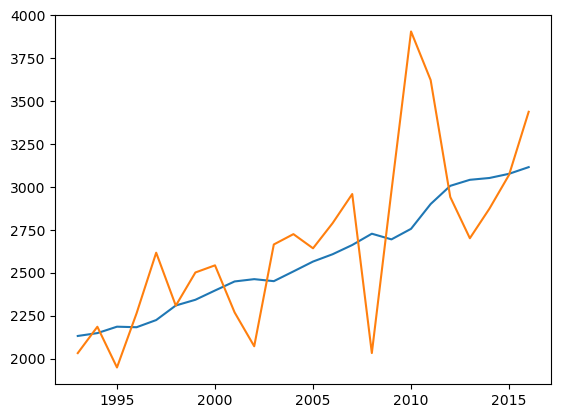

In [291]:
trend_estimated = []

for year in x_y_cv["year"].unique().tolist():
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)
    
plt.plot(x_y_cv["year"].unique().tolist(), trend_estimated)
plt.plot(x_y_cv["year"].unique().tolist(), x_y_cv["yield [kg/ha]"])

print(np.round(mse(trend_estimated, x_y_cv["yield [kg/ha]"].values.tolist(), squared=False), 2))

In [292]:
x_y_cv["yield_trend [kg/ha]"] = trend_estimated
x_y_cv["yield anomaly [kg/ha]"] = x_y_cv["yield [kg/ha]"] - x_y_cv["yield_trend [kg/ha]"]

In [307]:
municipalities = list(set([c.split("_")[2] if c not in ['year', 'yield [kg/ha]', 'yield_trend [kg/ha]', 'yield anomaly [kg/ha]'] else 'santa fe san cristobal' for c in x_y_cv.columns]))

### train and validate first model

In [372]:
best_rmse = 1e6
best_r = -1e6

for m in ["entre rios parana", "buenos aires coronel dorrego", "santa fe san cristobal"]:
    for no_of_features in list(range(1,9)):
        x_y_cv_temp = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == m] + ["yield_trend [kg/ha]", "yield anomaly [kg/ha]", "yield [kg/ha]", "year"]]
        #x_y_cv_temp = x_y_cv_temp.loc[:, [c for c in [l for l in x_y_cv_temp.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == m] + ["yield_trend [kg/ha]", "yield anomaly [kg/ha]", "yield [kg/ha]", "year"]]
        # have to be scaled
        scaler = StandardScaler()

        x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if ("rain" in c) or ("tmean" in c)]] = scaler.fit_transform(x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if ("rain" in c) or ("tmean" in c)]])

        x_y_cv_temp = (x_y_cv_temp
            .merge(pd
                   .DataFrame(np.array(x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if "rain" in c]]) * np.array(x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if "tmean" in c]]), 
                                  columns=["rt_8", "rt_9", "rt_10", "rt_11"]), 
                        left_index=True, right_index=True))
        
        X = x_y_cv_temp.loc[:, [c for c in x_y_cv_temp.columns if  ("_8" in c) or ("_9" in c) or ("_10" in c) or ("_11" in c)]]
        y = x_y_cv_temp["yield anomaly [kg/ha]"]

        pipeline = Pipeline([('scaler', StandardScaler()), 
                                    ('var', VarianceThreshold()), 
                                    ('selector', SelectKBest(f_regression, k=no_of_features)),
                                    ('estimator', Ridge())])

        # Perform LOOCV and obtain predictions
        loo = LeaveOneOut()
        y_pred = cross_val_predict(pipeline, X, y, cv=loo)

        rmse = np.round(mse(y_pred, y, squared=False), 2)
        r = np.round(pearsonr(y_pred, y)[0], 2)
        #if rmse < best_rmse: 
        #    best_rmse = rmse
        #    print(m)
        #    print(no_of_features)
        #if r > best_r: 
        #    best_r = r
        #    print(m)
        #    print(no_of_features)
        print("rmse is {} and pearson's r is {} for area {} with {} features".format(rmse, r, m, no_of_features))

rmse is 379.41 and pearson's r is 0.12 for area entre rios parana with 1 features
rmse is 365.64 and pearson's r is 0.27 for area entre rios parana with 2 features
rmse is 351.88 and pearson's r is 0.33 for area entre rios parana with 3 features
rmse is 335.39 and pearson's r is 0.43 for area entre rios parana with 4 features
rmse is 323.56 and pearson's r is 0.49 for area entre rios parana with 5 features
rmse is 314.65 and pearson's r is 0.53 for area entre rios parana with 6 features
rmse is 317.0 and pearson's r is 0.53 for area entre rios parana with 7 features
rmse is 318.22 and pearson's r is 0.52 for area entre rios parana with 8 features
rmse is 293.69 and pearson's r is 0.61 for area buenos aires coronel dorrego with 1 features
rmse is 307.24 and pearson's r is 0.55 for area buenos aires coronel dorrego with 2 features
rmse is 298.37 and pearson's r is 0.57 for area buenos aires coronel dorrego with 3 features
rmse is 287.43 and pearson's r is 0.61 for area buenos aires coron

In [272]:
X = x_y_cv0.loc[:, [c for c in x_y_cv0.columns if  ("_8" in c) or ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv0["yield anomaly [kg/ha]"]

pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=1)),
                             ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

#plt.plot(x_y_cv0["year"], y_pred, label="predicted");
#plt.plot(x_y_cv0["year"], y, label="observed");
#plt.legend();

rmse is 349.92 and pearson's r is 0.3


In [280]:
X = x_y_cv1.loc[:, [c for c in x_y_cv1.columns if  ("_8" in c) or ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv1["yield anomaly [kg/ha]"]

pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=7)),
                             ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

#plt.plot(x_y_cv1["year"], y_pred, label="predicted");
#plt.plot(x_y_cv1["year"], y, label="observed");
#plt.legend();

rmse is 463.51 and pearson's r is 0.05


In [373]:
x_y_cv0 = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == "entre rios parana"] + ["yield_trend [kg/ha]", "yield anomaly [kg/ha]", "yield [kg/ha]", "year"]]
x_y_cv1 = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == "buenos aires coronel dorrego"] + ["yield_trend [kg/ha]", "yield anomaly [kg/ha]", "yield [kg/ha]", "year"]]
x_y_cv2 = x_y_cv.loc[:, [c for c in [l for l in x_y_cv.columns if ("rain" in l) or ("tmean" in l)] if c.split("_")[2] == "santa fe san cristobal"] + ["yield_trend [kg/ha]", "yield anomaly [kg/ha]", "yield [kg/ha]", "year"]]

scaler = StandardScaler()

x_y_cv0.loc[:, [c for c in x_y_cv0.columns if ("rain" in c) or ("tmean" in c)]] = scaler.fit_transform(x_y_cv0.loc[:, [c for c in x_y_cv0.columns if ("rain" in c) or ("tmean" in c)]])
x_y_cv0 = (x_y_cv0
    .merge(pd
            .DataFrame(np.array(x_y_cv0.loc[:, [c for c in x_y_cv0.columns if "rain" in c]]) * np.array(x_y_cv0.loc[:, [c for c in x_y_cv0.columns if "tmean" in c]]), 
                            columns=["rt_8_0", "rt_9_0", "rt_10_0", "rt_11_0"]), 
                left_index=True, right_index=True))


x_y_cv1.loc[:, [c for c in x_y_cv1.columns if ("rain" in c) or ("tmean" in c)]] = scaler.fit_transform(x_y_cv1.loc[:, [c for c in x_y_cv1.columns if ("rain" in c) or ("tmean" in c)]])
x_y_cv1 = (x_y_cv1
    .merge(pd
            .DataFrame(np.array(x_y_cv1.loc[:, [c for c in x_y_cv1.columns if "rain" in c]]) * np.array(x_y_cv1.loc[:, [c for c in x_y_cv1.columns if "tmean" in c]]), 
                            columns=["rt_8_1", "rt_9_1", "rt_10_1", "rt_11_1"]), 
                left_index=True, right_index=True))

x_y_cv2.loc[:, [c for c in x_y_cv2.columns if ("rain" in c) or ("tmean" in c)]] = scaler.fit_transform(x_y_cv2.loc[:, [c for c in x_y_cv2.columns if ("rain" in c) or ("tmean" in c)]])
x_y_cv2 = (x_y_cv2
    .merge(pd
            .DataFrame(np.array(x_y_cv2.loc[:, [c for c in x_y_cv2.columns if "rain" in c]]) * np.array(x_y_cv2.loc[:, [c for c in x_y_cv2.columns if "tmean" in c]]), 
                            columns=["rt_8_2", "rt_9_2", "rt_10_2", "rt_11_2"]), 
                left_index=True, right_index=True))
        

x_y_cv012 = (x_y_cv0
            .merge(x_y_cv1.loc[:, [c for c in x_y_cv1.columns if ("rain" in c) or ("tmean" in c) or ("rt" in c) or (c == "year")]].
                   merge(x_y_cv2.loc[:, [c for c in x_y_cv2.columns if ("rain" in c) or ("tmean" in c) or ("rt" in c) or (c == "year")]], on="year"),  on=["year"]))
x_y_cv012.columns

Index(['rain_8_entre rios parana', 'rain_9_entre rios parana',
       'rain_10_entre rios parana', 'rain_11_entre rios parana',
       'tmean_8_entre rios parana', 'tmean_9_entre rios parana',
       'tmean_10_entre rios parana', 'tmean_11_entre rios parana',
       'yield_trend [kg/ha]', 'yield anomaly [kg/ha]', 'yield [kg/ha]', 'year',
       'rt_8_0', 'rt_9_0', 'rt_10_0', 'rt_11_0',
       'rain_8_buenos aires coronel dorrego',
       'rain_9_buenos aires coronel dorrego',
       'rain_10_buenos aires coronel dorrego',
       'rain_11_buenos aires coronel dorrego',
       'tmean_8_buenos aires coronel dorrego',
       'tmean_9_buenos aires coronel dorrego',
       'tmean_10_buenos aires coronel dorrego',
       'tmean_11_buenos aires coronel dorrego', 'rt_8_1', 'rt_9_1', 'rt_10_1',
       'rt_11_1', 'rain_8_santa fe san cristobal',
       'rain_9_santa fe san cristobal', 'rain_10_santa fe san cristobal',
       'rain_11_santa fe san cristobal', 'tmean_8_santa fe san cristobal',
    

rmse is 277.57 and pearson's r is 0.65


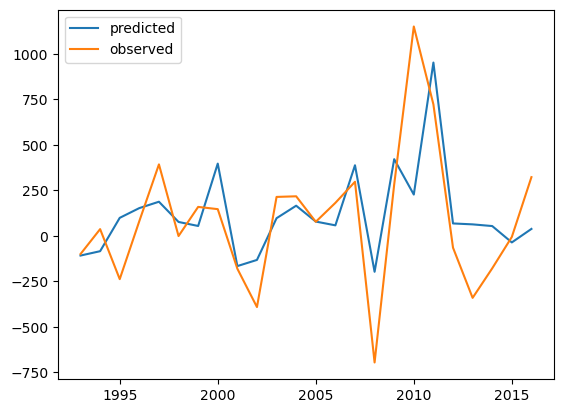

In [383]:
X = x_y_cv012.loc[:, [c for c in x_y_cv012.columns if ("_8" in c) or ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv012["yield anomaly [kg/ha]"]

pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=2)),
                             ('estimator', Ridge())])

# Perform LOOCV and obtain predictions
loo = LeaveOneOut()
y_pred = cross_val_predict(pipeline, X, y, cv=loo)

rmse = np.round(mse(y_pred, y, squared=False), 2)
r = np.round(pearsonr(y_pred, y)[0], 2)
print("rmse is {} and pearson's r is {}".format(rmse, r))

plt.plot(x_y_cv01["year"], y_pred, label="predicted");
plt.plot(x_y_cv01["year"], y, label="observed");
plt.legend();

In [368]:
np.round(100 * rmse/(y.max()-y.min()), 2)

15.29

In [200]:
x_y_cv["absolute yield prediction"] = x_y_cv[["year", "var_predicted"]].apply(lambda x: x[0] * years_to_params[x[0]]["slope"] + years_to_params[x[0]]["bias"] + x[1], axis=1)

rmse is 369.83


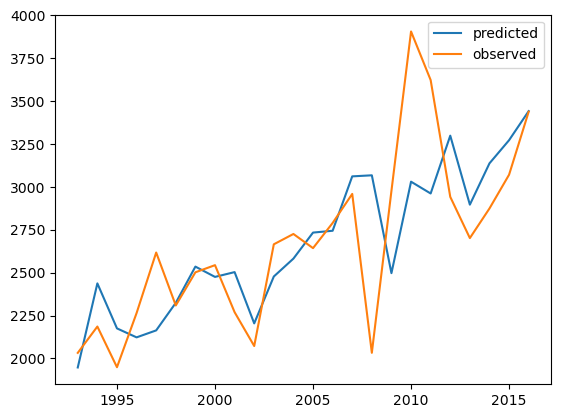

In [202]:
rmse = np.round(mse(x_y_cv["absolute yield prediction"], x_y_cv["yield [kg/ha]"], squared=False), 2)
#r = np.round(pearsonr(x_y_cv["absolute yield prediction"], x_y_cv["yield [kg/ha]"])[0], 2)
print("rmse is {}".format(rmse))

plt.plot(x_y_cv["year"], x_y_cv["absolute yield prediction"], label="predicted");
plt.plot(x_y_cv["year"], x_y_cv["yield [kg/ha]"], label="observed");
plt.legend();